#### Enesimum attemp to make a decent dimplification of WDPA

### Mapshaper commad used in Marxan:
!mapshaper -i /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825.shp snap combine-files \
        -simplify 25% planar keep-shapes \
        -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
        -filter-slivers min-area=10000m2 remove-empty \
        -clean rewind \
        -o /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825_simple.shp format=shapefile force ndjson

In [ ]:
# !pip install pandarallel

In [ ]:
# ## In terminal run to install mapshaper:
# !nvm use 12.21.0
# !npm i -g mapshaper@0.5.67

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas
import os
import json
# from pandarallel import pandarallel
# import topojson as tp
from zipfile import ZipFile
# pandarallel.initialize(progress_bar=True, use_memory_fs=False, nb_workers=20)

In [4]:
# Create unzipped folder so mapshaper can bring the shp
zipfile = '/Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol'
unzipfile = ZipFile(f'{zipfile}.zip').extractall(zipfile)
# file_in = f'{zipfile}/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol.shp'
# file_out = '/Users/sofia/Documents/HE_Data/WDPA_simple.shp'

In [ ]:
### Inspect file
# gdf = gpd.read_file(file_in)

In [5]:
# Read file
gdf = gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol.zip')
len(gdf)

224133

In [ ]:
gdf.columns

In [7]:
# Create subset with only relevant columns
sub = gdf[['WDPA_PID','NAME','ORIG_NA','DESIG','DESIG_E','DESIG_T','IUCN_CA','MARINE','GOV_TYP','ISO3','OWN_TYP','AREA_KM','MOL_ID','geometry']]

#### Simplification is done in the he-scratch folder, but the outputs have been removed to avoid space issues
Note: Run the mapshaper commands directly in terminal if it doesn't work here

#### Create partitions to make the process more efficient

In [ ]:
# Break the shp into 12 json files
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

In [ ]:
## To merge all json files in one
# !mapshaper-xl 16gb -i ./../../HALF_EARTH/WDPA_test/*.json snap combine-files -merge-layers -info

### Tests:
1. All commands: len 183665 (symp-wdpa.shp)
2. Remove the 'filter-slivers' option = len 19833 (symp-wdpa2.shp)
3. Remove the 'filter-slivers' and 'filter islands' option = len (symp-wdpa3.shp)
This option removes >8000 geometries but all of them (except for 1) are valid
4. Remove the clean rewind option.
The 4th option retains all geometries, but 3935 are invalid. Some of those can be repaired and only 1611 have to be removed.

##### * Each test changes the json files so to run a new test it's necessary to run the previous cells to create the partitions again

In [ ]:
### First test with all parameters
# !mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
#     -simplify 20% planar keep-shapes \
#     -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
#     -filter-slivers min-area=10000m2 remove-empty \
#     -clean rewind \
#     -o WDPA_test/ format=geojson force ndjson

In [ ]:
### Final test: Only simplify (retains all geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 20% planar keep-shapes \
    -o WDPA_test/ format=geojson force ndjson

In [8]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/simp-wdpa4.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
--------------------------------------------------
Type:     polygon
Records:  224,133
Nulls:     1,610
Bounds:   -180,-85.4119,180,86.4531
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
------------+-------------------------------------
 Field      | First value
------------+-------------------------------------
 AREA_KM    |          1.136031298847187
 CONS_OB    | 'Not Applicable'
 DESIG      | 'Stewardship Area'
 DESIG_E    | 'Stewardship Area'
 DESIG_T    | 'National'
 GIS_ARE    |          1.13580554631289
 GIS_M_A    |          0
 GOV_TYP    | 'Federal or national ministry or agency'
 group      |          1
 hash_vl    | 1802338827
 INT_CRI    | 'Not Applicable'
 ISO3       | 'NZL'
 IUCN_CA    | 'III'
 MANG_AU    | 'Department of Conservation'
 MANG_PL    | 'Not Reported'
 MARINE     | '0'
 METADAT    |       1773
 MOL_ID     |          1
 NAME       | 'Boulder Beach'
 NO_TAKE  

In [9]:
### Inspect file
# original layer len 224133
#sim = gpd.read_file('WDPA_test/simp-wdpa.shp') # len 183665
#sim = gpd.read_file('WDPA_test/simp-wdpa2.shp') # len 19833
#sim = gpd.read_file('WDPA_test/simp-wdpa3.shp') # len 215940 ### with clean rewind (8193 geometries removed)
sim = gpd.read_file('WDPA_test/simp-wdpa4.shp') # len 224133 ### retains all geometries
len(sim)

224133

In [10]:
## Subset with only relevant columns
sim = sim.set_crs('EPSG:4326') # crs needs to be added
sub = sim[['WDPAID','WDPA_PID','NAME','ORIG_NA','DESIG','DESIG_E','DESIG_T','IUCN_CA','MARINE','GOV_TYP','ISO3','OWN_TYP','AREA_KM','MOL_ID','STATUS','geometry']]
sub.to_file('WDPA_test/simp-wdpa4_sub.shp')

In [11]:
## Check if there are invalid geometries
sum(sub.is_valid) # 220198 are valid so 3935 are invalid

220198

In [14]:
## Repair geometries and check how many are valid
sub2 = sub.buffer(0) # this is to repair geometries
sum(sub2.is_valid) # now 222522 geometries valid so only 1611 invalid

222523

In [16]:
# Change original geometry column with the repaired one
sub['geometry']= sub2 # change original geometry column for the one with repaired geometries
len(sub)

224133

In [17]:
## Keep only valid geometries and remove the 1611 invalid
sub_clean = sub[sub['geometry'].is_valid]
len(sub_clean)

222523

<AxesSubplot:>

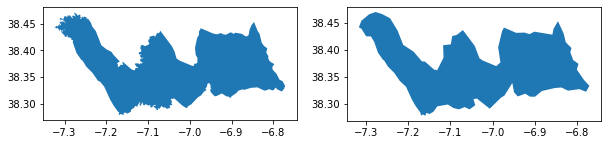

In [18]:
## Example
n= 555538632
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
sub_clean[sub_clean['WDPAID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

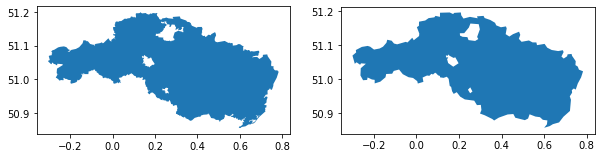

In [19]:
## Example
n = 20609
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
sub_clean[sub_clean['WDPAID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

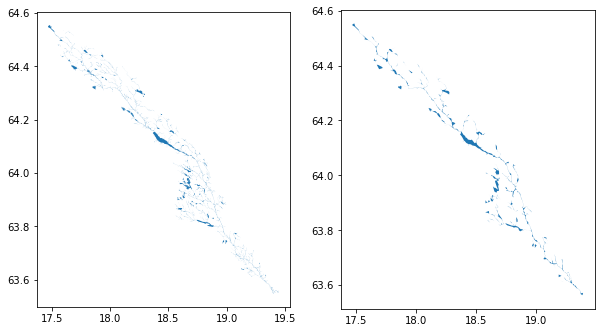

In [20]:
## Example
n = 555534655
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
sub_clean[sub_clean['WDPAID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

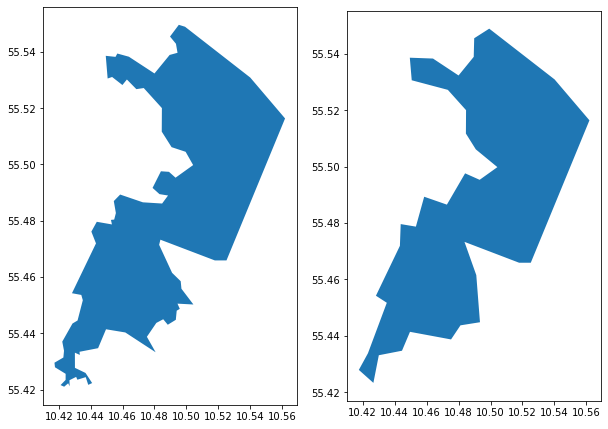

In [21]:
## Example
n = 555703244 
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
sim[sim['WDPAID']==n].geometry.plot(ax = ax2)

In [37]:
# Save file in local
sub_clean.to_file('/Users/sofia/Documents/HE_Data/WDPA_simplification', driver= 'ESRI Shapefile')

#### Check invalid geometries that were removed

In [22]:
# List the invalid geometries that were removed from dataset
ls = list(sub['WDPAID'])
ls2 = list(sub_clean['WDPAID'])
invalid= []
for element in ls:
    if element not in ls2:
        invalid.append(element)
len(invalid)

1610

In [24]:
invalid[1549]

555545970

In [25]:
gdf[gdf['WDPAID']==555545970]

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
173607,555545970.0,555545970,1,Robles De Irañeta,Robles De Irañeta,Monumento Natural,Natural Monument,National,III,Not Applicable,...,ESP,Not Applicable,Not Applicable,0.0,b48a0b59,-916676897,-916676897,0.000016,173608,"MULTIPOLYGON (((-1.93738 42.90105, -1.93737 42..."


<AxesSubplot:>

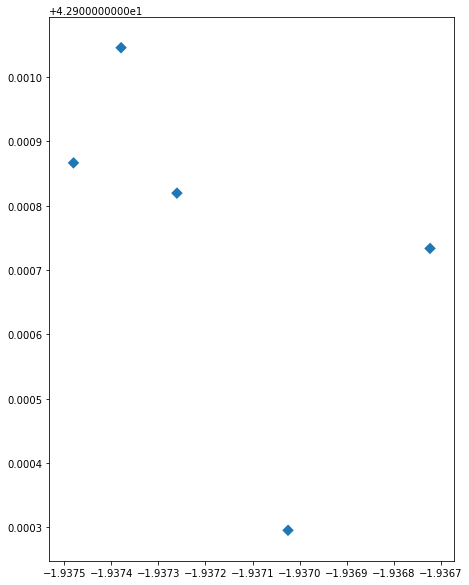

In [26]:
n = 555545970 # this one is gone in new dataset
fig, (ax1) = plt.subplots(figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
# sim[sim['WDPAID']==n].geometry.plot(ax = ax2)

#### Publish layers with API

In [27]:
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy

In [28]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

aol_password = env['aol_key']
aol_username = env['aol_username']

gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password)

In [31]:
# Function to publish files as feature services or hosted tables

def publishCSVasFS(csv_file,csvName, gis, aol_folder_name, sharing, table): # sharing = 'None', 'groups', 'everyone' # table = 'yes', 'no'
    try:
        
        if gis.content.is_service_name_available(csvName, "featureService"):
            print(f"Service name {csvName} is available")
            #csv_file = f'./{csvName}.csv'
            csv_item = gis.content.add({}, csv_file)
            #csv_lyr = csv_item.publish(None,  {'CountryCode' : 'countryname'})
            if table == 'yes':
                csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})
            else:
                print('no table')
                csv_lyr = csv_item.publish()
                flayer_collection = FeatureLayerCollection.fromitem(csv_lyr)
                searched_flayer = flayer_collection.layers[0] 
                nber_features = searched_flayer.query(return_count_only=True)
                print(f"The service {csvName} has been published. The service has {nber_features} entries")
            print(f"Moving service {csvName} to {aol_folder_name} in ArcGIS Online...")
            # move both the csv_item and csv_lyr items into this new folder
            csv_item.move(aol_folder_name)
            csv_lyr.move(aol_folder_name)
            print(f"Service {csvName} has been moved to {aol_folder_name} in ArcGIS Online")
#             sharing, default is owner
#             csv_lyr.shared_with
            if sharing == 'None':
                csv_lyr.share(everyone=False, org=False, groups=None, allow_members_to_edit=False)
            if sharing == 'groups':
            # the group id is needed to share with agroup
                csv_lyr.share(everyone=False, org=False, groups=[group_id], allow_members_to_edit=False)
            if sharing == 'everyone':
                csv_lyr.share(everyone=True, org=False, groups=None, allow_members_to_edit=False)
            sharing_prop = csv_lyr.shared_with
            if sharing_prop['everyone']==True:
                print(f"shared with everyone")   
            else:
                print(f"not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted")            
            #not allowing deleting
            csv_lyr.protect()
            print(f"{csvName}'s protection against deletion : {csv_lyr.protected}") 
            # it is possible to check the status with csv_item.content_status
            return csv_lyr.id
        else:
            print("The service name is not available, try overwritting, appending the data or a different service name")
    except:
        print("The csv hasn't been published")

In [40]:
# Run function with the file we want to add
csv_file = '/Users/sofia/Documents/HE_Data/WDPA_simplification.zip'
csvName = 'wdpa_simplification'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password)
aol_folder_name = '#6 precalculated data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='groups', table='no')

Service name wdpa_simplification_2 is available
no table
The service wdpa_simplification_2 has been published. The service has 222523 entries
Moving service wdpa_simplification_2 to #6 precalculated data in ArcGIS Online...
Service wdpa_simplification_2 has been moved to #6 precalculated data in ArcGIS Online
not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted
wdpa_simplification_2's protection against deletion : True


'176b65c97a8e42ef8738fef05def4ad5'